# Signal Performance

In [1]:
import os
import sys 
import numpy as np
import pandas as pd
import seaborn as sns
from   tqdm import tqdm

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FundamentalFlow\root\src")
from SignalOLS import SignalOLS
df = SignalOLS().full_sample_ols()

## Individual Signal Performance

In [3]:
def get_security_sharpe(df: pd.DataFrame) -> pd.DataFrame:
    
    df_sharpe = (df[
        ["security", "variable", "signal_rtn"]].
        groupby(["security", "variable"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_security_sharpe = get_security_sharpe(df)

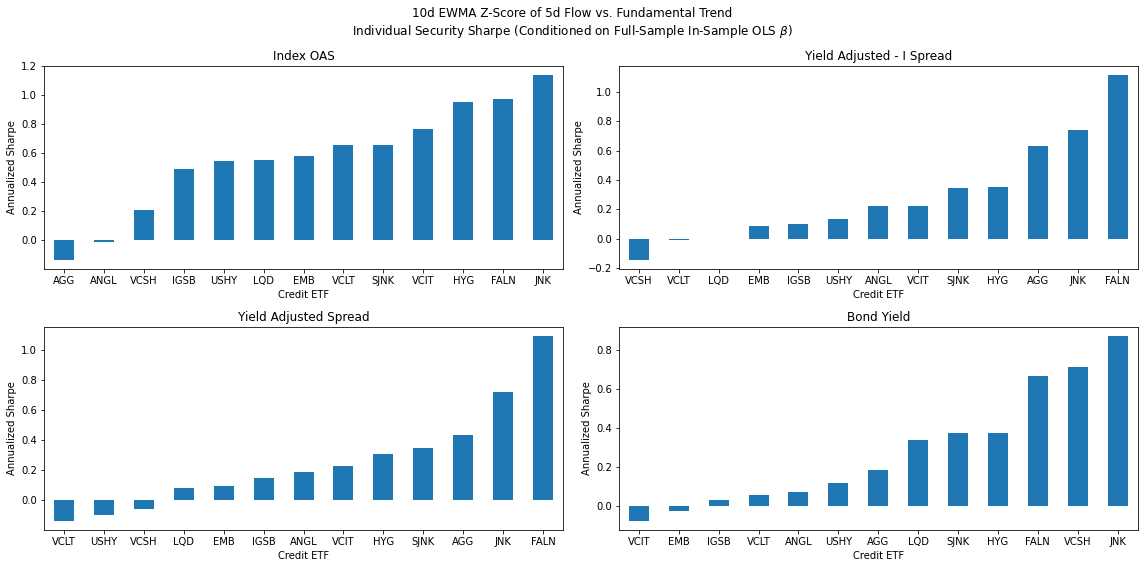

In [4]:
def plot_security_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure:
    
    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted - I Spread",
        "yas_sprd"   : "Yield Adjusted Spread",
        "yas_yls"    : "Bond Yield"}

    variables = df_sharpe.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (16,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_sharpe.query(
            "variable == @variable").
            set_index("security")
            [["sharpe"]].
            sort_values("sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "Credit ETF",
                rot    = 0,
                ylabel = "Annualized Sharpe",
                legend = False,
                title  = renamer[variable]))

    fig.suptitle("10d EWMA Z-Score of 5d Flow vs. Fundamental Trend\nIndividual Security Sharpe (Conditioned on Full-Sample In-Sample OLS " + r"$\beta$)")
    plt.tight_layout()
    
plot_security_sharpe(df_security_sharpe)

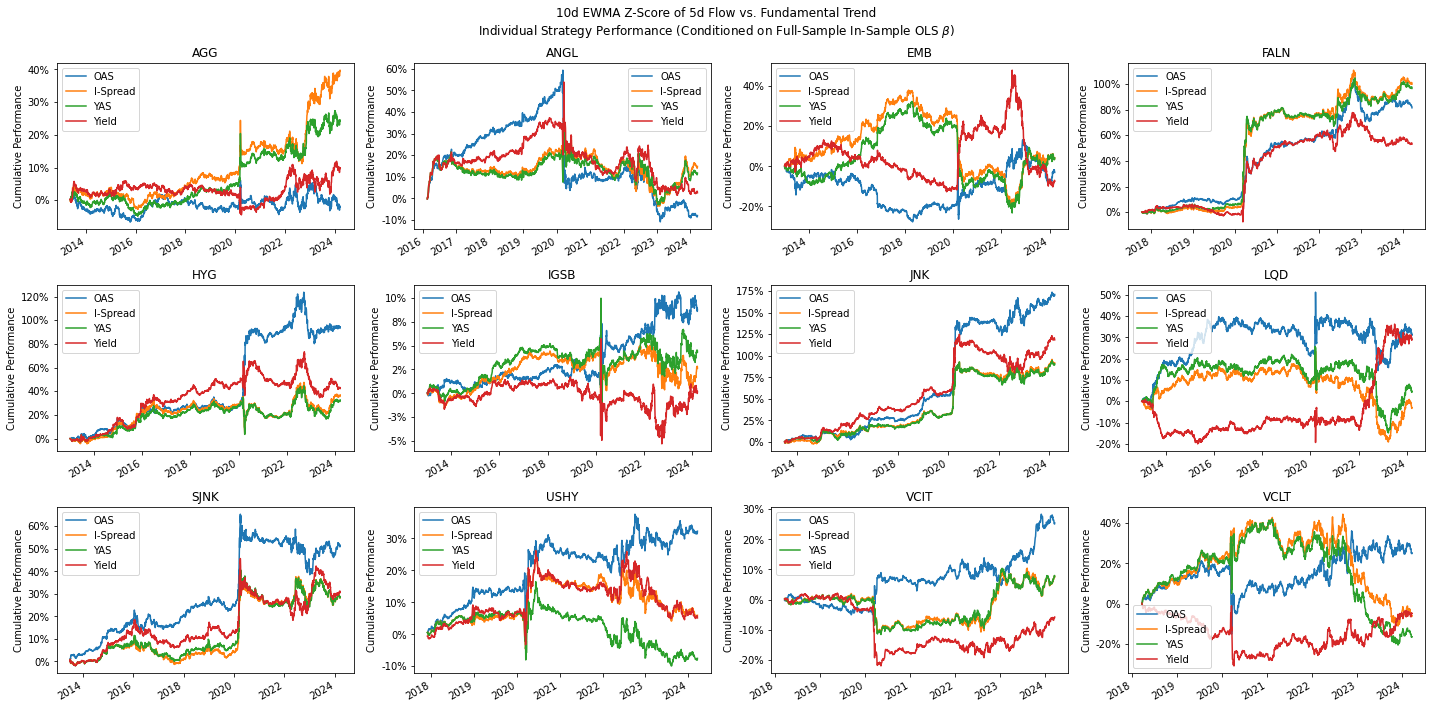

In [5]:
def plot_security_rtn(df: pd.DataFrame) -> plt.Figure: 

    renamer = {
        "wac"        : "WAC",
        "yas_ispread": "I-Spread",
        "yas_sprd"   : "YAS",
        "yas_yls"    : "Yield"}

    variables = df.security.drop_duplicates().sort_values().to_list()

    fig, axes = plt.subplots(ncols = len(variables) // 3, nrows = len(variables) // 4, figsize = (20,10))
    for variable, ax in zip(variables, axes.flatten()):

        (df.query(
            "security == @variable").
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            rename(columns = renamer).
            dropna().
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                title  = variable,
                ax     = ax,
                ylabel = "Cumulative Performance",
                xlabel = ""))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("10d EWMA Z-Score of 5d Flow vs. Fundamental Trend\nIndividual Strategy Performance (Conditioned on Full-Sample In-Sample OLS " + r"$\beta$)")
    plt.tight_layout()
    
plot_security_rtn(df)

## Average Portfolio Returns

In [6]:
def get_avg_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df[
        ["date", "variable", "signal_rtn"]].
        groupby(["date", "variable"]).
        agg("mean").
        reset_index())
    
    return df_out

df_avg_rtn = get_avg_rtn(df)

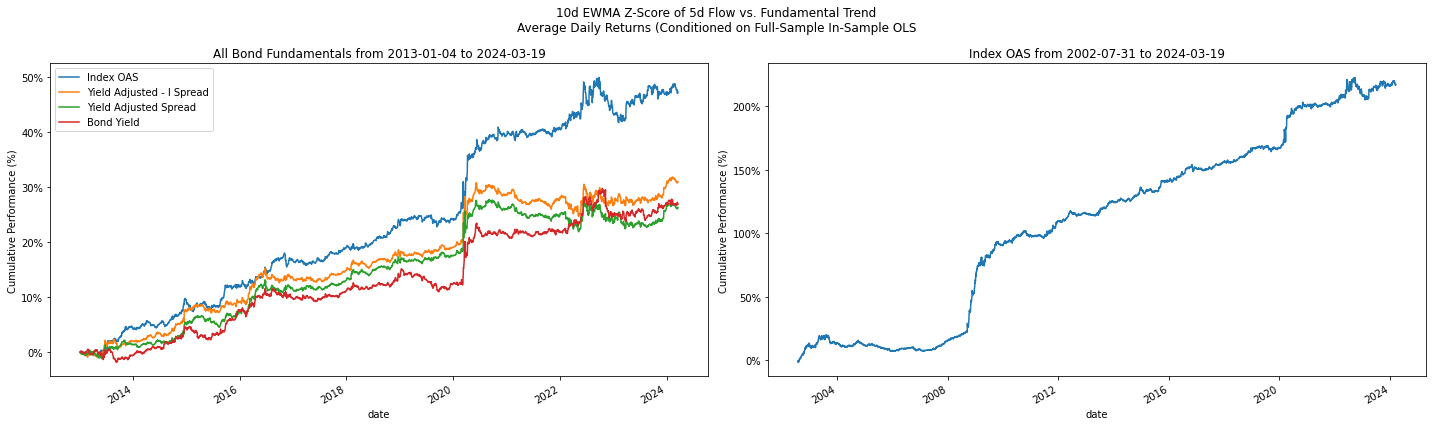

In [7]:
def plot_avg_rtn(df_avg_rtn: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted - I Spread",
        "yas_sprd"   : "Yield Adjusted Spread",
        "yas_yls"    : "Bond Yield"}

    df_plot = (df_avg_rtn.rename(
        columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        rename(columns = renamer))
        
    (df_plot.dropna().apply(
        lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[0],
            title = "All Bond Fundamentals from {} to {}".format(
                df_avg_rtn.query("variable != 'OAS'").date.min().date(),
                df_avg_rtn.query("variable != 'OAS'").date.max().date())))
    
    (df_plot[
        ["Index OAS"]].
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes[1],
            legend = False,
            title  = "Index OAS from {} to {}".format(
                df_plot.index.min().date(),
                df_plot.index.max().date())))

    for ax in axes.flatten(): 
        
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
        ax.set_ylabel("Cumulative Performance (%)")
    
    fig.suptitle("10d EWMA Z-Score of 5d Flow vs. Fundamental Trend\nAverage Daily Returns (Conditioned on Full-Sample In-Sample OLS")
    plt.tight_layout()
    
plot_avg_rtn(df_avg_rtn)

In [8]:
def get_avg_sharpe(df_avg_rtn: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df_avg_rtn.drop(
        columns = ["date"]).
        groupby("variable").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_out

df_sharpe = get_avg_sharpe(df_avg_rtn)

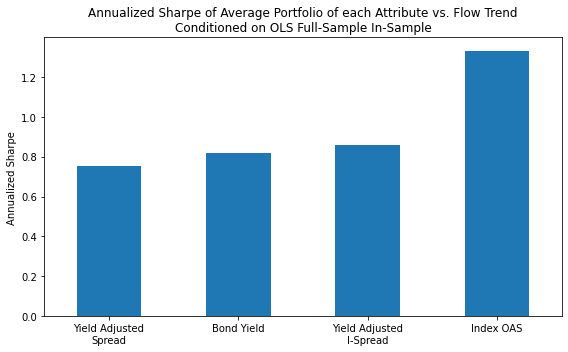

In [9]:
def plot_avg_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted\nI-Spread",
        "yas_sprd"   : "Yield Adjusted\nSpread",
        "yas_yls"    : "Bond Yield"}

    (df_sharpe[
        ["sharpe"]].
        reset_index().
        replace(renamer).
        set_index("variable").
        sort_values("sharpe").
        plot(
            kind    = "bar",
            legend  = False,
            figsize = (8,5),
            rot     = 0,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of Average Portfolio of each Attribute vs. Flow Trend\nConditioned on OLS Full-Sample In-Sample"))
    
    plt.tight_layout()
    
plot_avg_sharpe(df_sharpe)

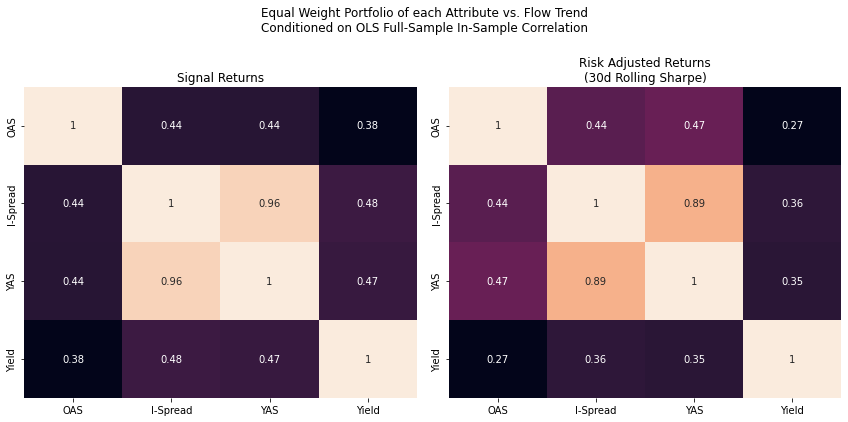

In [10]:
def plot_avg_portfolio_corr(df_avg_rtn: pd.DataFrame) -> plt.Figure:
    
    renamer = {
        "wac"        : "WAC",
        "yas_ispread": "I-Spread",
        "yas_sprd"   : "YAS",
        "yas_yls"    : "Yield"}

    df_wider = (df_avg_rtn.pivot(
        index = "date", columns = "variable", values = "signal_rtn").
        rename(columns = renamer))

    df_adj = (df_wider.rolling(window = 30).mean() / df_wider.rolling(window = 30).std()).dropna()

    df_rtn_corr = df_wider.corr()
    df_adj_corr = df_adj.corr()

    fig, axes = plt.subplots(ncols = 2, figsize = (12,6))

    (sns.heatmap(
        data = df_rtn_corr,
        annot = True,
        ax    = axes[0],
        cbar  = False))

    (sns.heatmap(
        data = df_adj_corr,
        annot = True,
        ax    = axes[1],
        cbar  = False))

    for ax in axes.flatten(): 

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis = "x", rotation = 0)

    axes[0].set_title("Signal Returns")
    axes[1].set_title("Risk Adjusted Returns\n(30d Rolling Sharpe)")

    fig.suptitle("Equal Weight Portfolio of each Attribute vs. Flow Trend\nConditioned on OLS Full-Sample In-Sample Correlation")
    plt.tight_layout(pad = 1.5)
    
plot_avg_portfolio_corr(df_avg_rtn)

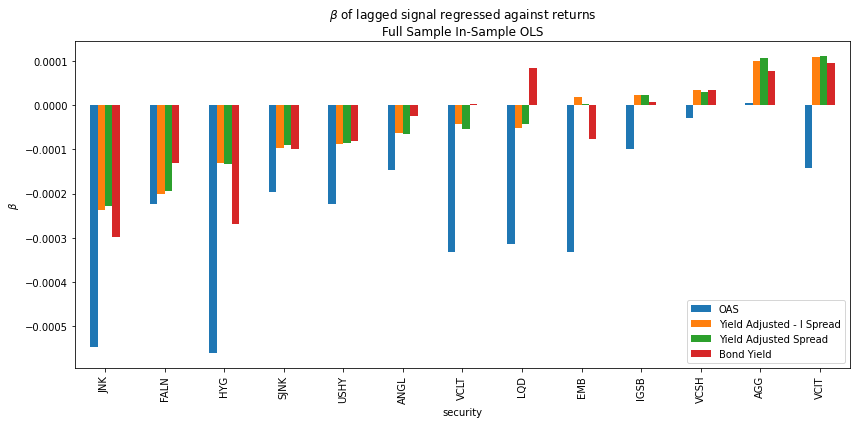

In [11]:
def plot_beta(df: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "wac"        : "Weighted Average Coupon",
        "yas_ispread": "Yield Adjusted - I Spread",
        "yas_sprd"   : "Yield Adjusted Spread",
        "yas_yls"    : "Bond Yield"}

    (df[
        ["security", "variable", "param_val"]].
        drop_duplicates().
        rename(columns = {"variable": ""}).
        pivot(index = "security", columns = "", values = "param_val").
        sort_values("yas_sprd").
        rename(columns = renamer).
        plot(
            kind    = "bar",
            figsize = (12,6),
            ylabel  = r"$\beta$",
            title   = r"$\beta$" + " of lagged signal regressed against returns\nFull Sample In-Sample OLS"))
    
    plt.tight_layout()
    
plot_beta(df)

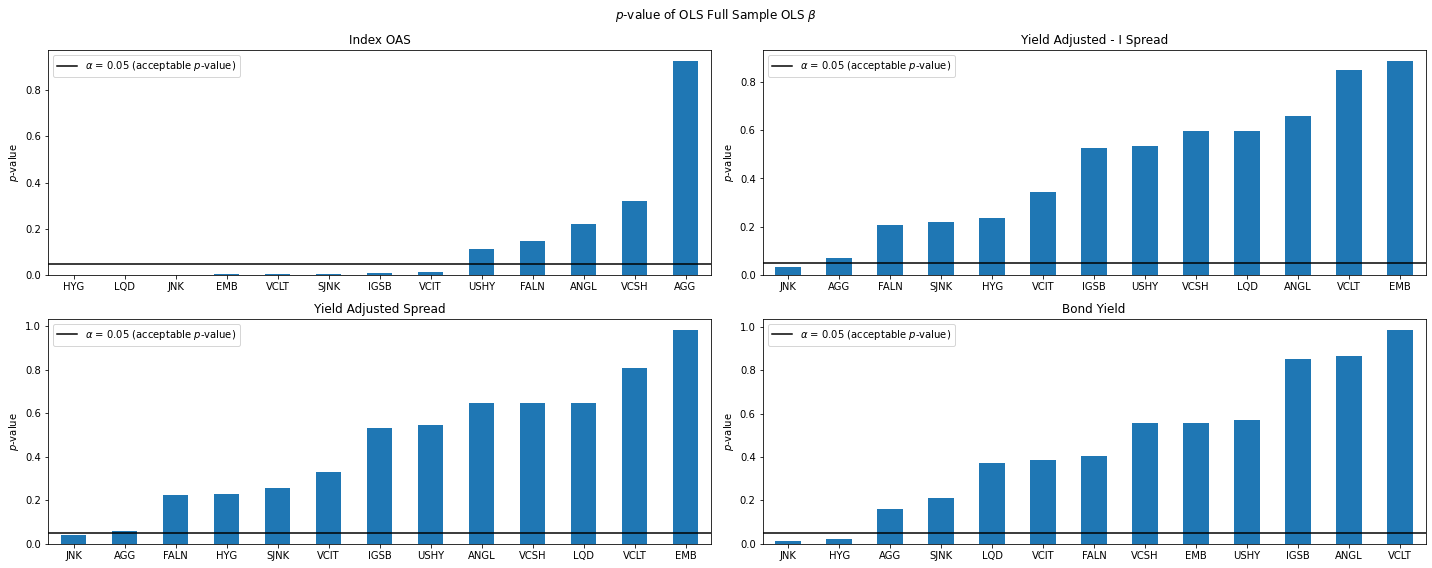

In [12]:
def plot_pvalue(df: pd.DataFrame) -> plt.Figure:
    
    df_tmp = (df[
        ["security", "variable", "pvalue"]].
        drop_duplicates())

    renamer = {
        "OAS"        : "Index OAS",
        "yas_ispread": "Yield Adjusted - I Spread",
        "yas_sprd"   : "Yield Adjusted Spread",
        "yas_yls"    : "Bond Yield"}

    variables = df_tmp.variable.drop_duplicates().sort_values()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_tmp.query(
            "variable == @variable").
            set_index("security").
            sort_values("pvalue").
            rename(columns = {"pvalue": ""}).
            plot(
                ax     = ax,
                kind   = "bar",
                legend = False,
                title  = renamer[variable],
                ylabel = r"$p$-value",
                xlabel = "",
                rot    = 0))

        ax.axhline(y = 0.05, color = "black", label = r"$\alpha$ = 0.05 (acceptable $p$-value)")
        ax.legend()

    fig.suptitle(r"$p$-value of OLS Full Sample OLS $\beta$")
    plt.tight_layout()
    
plot_pvalue(df)

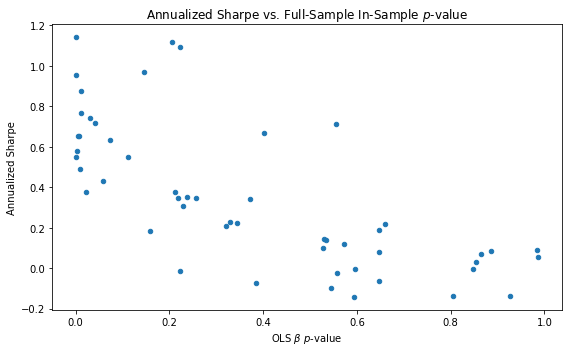

In [13]:
def plot_pvalue_sharpe(df: pd.DataFrame, df_security_sharpe: pd.DataFrame) -> plt.Figure:
    
    (df[
        ["security", "pvalue", "variable"]].
        drop_duplicates().
        merge(right = df_security_sharpe, how = "inner", on = ["security", "variable"]).
        plot(
            kind    = "scatter", 
            x       = "pvalue", 
            y       = "sharpe",
            xlabel  = r"OLS $\beta$ $p$-value",
            ylabel  = "Annualized Sharpe",
            title   = r"Annualized Sharpe vs. Full-Sample In-Sample $p$-value",
            figsize = (8,5)))

    plt.tight_layout()
    
plot_pvalue_sharpe(df, df_security_sharpe)